## **Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

**Name:** Mandeep Singh Brar        
**Student ID:** 8989367     
**Course Name:** Foundations of Machine Learning Frameworks         
**Course No:** CSCN8010 


### **Introduction**

In this lab, I will explore the task of image classification by building a model that can distinguish between images of dogs and cats. 

To understand the strengths of different modeling approaches, I will implement two models:

- A Vanilla CNN built from scratch to grasp the core mechanics of convolutional networks.

- A Fine-Tuned VGG16 model that applies transfer learning using pre-trained ImageNet weights.

Through this process, I aim to deepen my understanding of deep learning workflows, including data preprocessing, model training, evaluation, and fine-tuning. I will evaluate both models using accuracy, precision, recall, F1-score, and confusion matrix to determine which approach performs best for this binary classification task.

#### **Step 1: Obtain the Dataset (Dogs vs. Cats)**

I downloaded the Dogs vs. Cats dataset from Kaggle, available here: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

The full dataset contains 25,000 images, but for the purpose of this lab—and in line with the provided class notebook—I only need a subset of 5,000 images, equally balanced between dogs and cats for training, validation, and testing.

#### **Step 2: Extract and Organize the Dataset**        

After downloading the train.zip file, I extracted it into a folder of my choice.

In [1]:
import os, shutil, pathlib
from pathlib import Path

# Define paths for the original dataset and the destination for the smaller subset
original_dir = pathlib.Path("Data/train")  # Folder containing all 25,000 original images
new_base_dir = pathlib.Path("Data/cats_vs_dogs")  # Folder where the smaller, organized dataset will be saved

# Function to create subsets (train, validation, test) from the full dataset
def make_subset(subset_name, start_index, end_index):
    print(f"\n Creating subset: {subset_name} ({start_index} to {end_index - 1})")
    print("----")

    # Loop over both categories: cats and dogs
    for category in ("cat", "dog"):
        # Create the directory for the current subset and category if it doesn’t exist
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        # Generate file names like 'cat.0.jpg', 'dog.1001.jpg', etc.
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        copied = 0  # Counter to track number of copied files

        # Copy each image from the original dataset to the new directory
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if src.exists():
                shutil.copyfile(src, dst)
                copied += 1
            else:
                # Warn if a file in the expected range is missing
                print(f"Warning: {fname} not found in {original_dir}")

        print(f"Copied {copied} images to '{subset_name}/{category}'")

# Run the function for each subset: train (1000 per class), validation (500 per class), test (1000 per class)
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

print("\n")
print(" Dataset split completed successfully.")



 Creating subset: train (0 to 999)
----
Copied 1000 images to 'train/cat'
Copied 1000 images to 'train/dog'

 Creating subset: validation (1000 to 1499)
----
Copied 500 images to 'validation/cat'
Copied 500 images to 'validation/dog'

 Creating subset: test (1500 to 2499)
----
Copied 1000 images to 'test/cat'
Copied 1000 images to 'test/dog'


 Dataset split completed successfully.


### **EDA: Explore the data with relevant graphs, statistics and insights**

#### **Step 1: Dataset Structure and Class Distribution**

In this step, I summarize the number of images in each class (cats and dogs) across all three subsets: training, validation, and test. This helps confirm that the dataset is balanced, which is essential for training unbiased models.

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Function to count images in each subset and class
def summarize_dataset(new_base_dir):
    data = {"Subset": [], "Class": [], "Image Count": []}
    for subset in ["train", "validation", "test"]:
        for cls in ["cat", "dog"]:
            path = new_base_dir / subset / cls
            count = len(os.listdir(path))
            data["Subset"].append(subset.capitalize())
            data["Class"].append(cls.capitalize())
            data["Image Count"].append(count)
    return pd.DataFrame(data)

# Generate summary DataFrame
df_summary = summarize_dataset(new_base_dir)
df_summary


,Subset,Class,Image Count
0,Train,Cat,1000
1,Train,Dog,1000
2,Validation,Cat,500
3,Validation,Dog,500
4,Test,Cat,1000
5,Test,Dog,1000


#### **Step 2: Visual Inspection of Sample Images**
Here, I randomly visualize a few images from each class to gain an understanding of the image content, quality, and visual diversity. This is useful for spotting potential issues or biases before preprocessing.

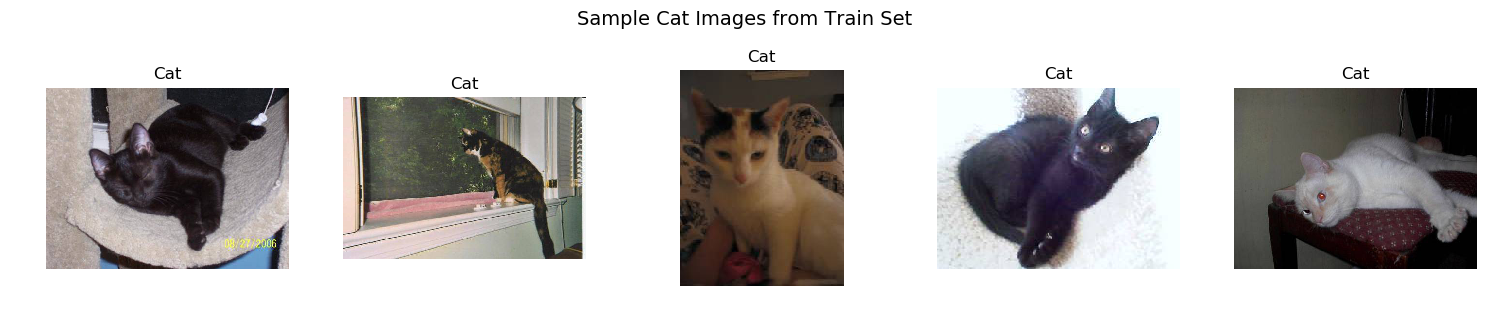

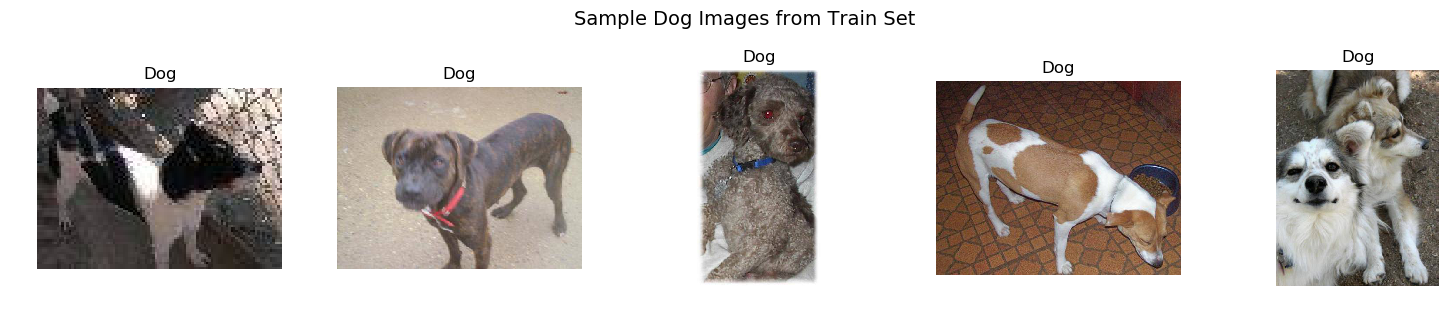

In [3]:
import matplotlib.image as mpimg
import random

# Function to show 5 random training images from a specified label
def show_images(label):
    
    # Path to training images for the given label
    img_folder = os.path.join(new_base_dir, 'train', label)
    img_files = random.sample(os.listdir(img_folder), 5)

    # Create a figure and plot the images in a row
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(img_files):
        img_path = os.path.join(img_folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(label.capitalize())
        plt.axis('off')

    # Add title and spacing between title and plots
    plt.suptitle(f"Sample {label.capitalize()} Images from Train Set", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust vertical space for suptitle
    plt.show()

# 🔍 Show samples from both classes
show_images('cat')
show_images('dog')


#### **Step 3: Image Dimension Distribution**
This step analyzes the width and height of sample images to determine if resizing is necessary. Since CNNs require fixed input sizes, it's important to assess and standardize image dimensions.

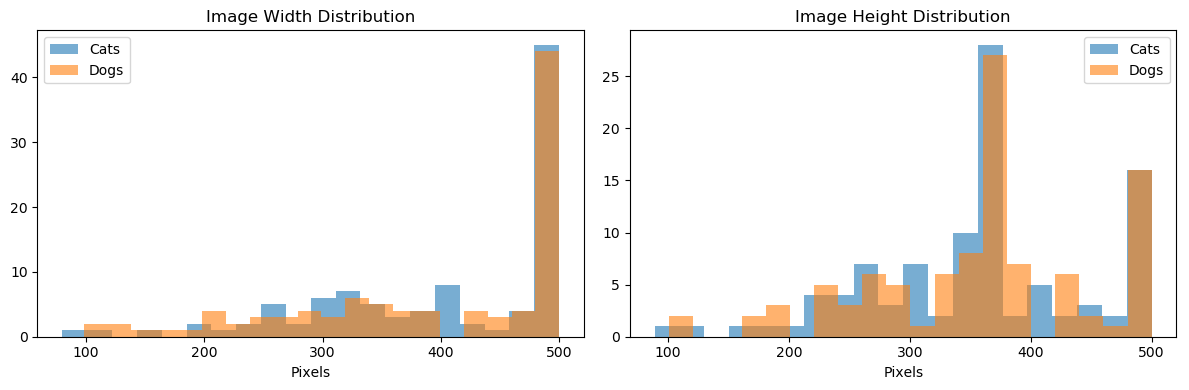

In [4]:
# Analyze image width and height to assess the need for resizing
from PIL import Image
import numpy as np

# Function to extract image sizes from a sample set
def image_sizes(folder):
    sizes = []
    for file in os.listdir(folder)[:100]:  # Limit to first 100 for speed
        with Image.open(folder / file) as img:
            sizes.append(img.size)
    return sizes

# Collect dimensions
cat_sizes = image_sizes(new_base_dir / "train" / "cat")
dog_sizes = image_sizes(new_base_dir / "train" / "dog")

# Separate width and height
cat_w, cat_h = zip(*cat_sizes)
dog_w, dog_h = zip(*dog_sizes)

# Plot image width and height distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(cat_w, bins=20, alpha=0.6, label="Cats")
plt.hist(dog_w, bins=20, alpha=0.6, label="Dogs")
plt.title("Image Width Distribution")
plt.xlabel("Pixels")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cat_h, bins=20, alpha=0.6, label="Cats")
plt.hist(dog_h, bins=20, alpha=0.6, label="Dogs")
plt.title("Image Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.tight_layout()
plt.show()


#### **Step 4: Brightness Analysis**
I convert images to grayscale and calculate average brightness values. This helps evaluate whether lighting conditions vary drastically across images, which could affect model performance if not handled properly.

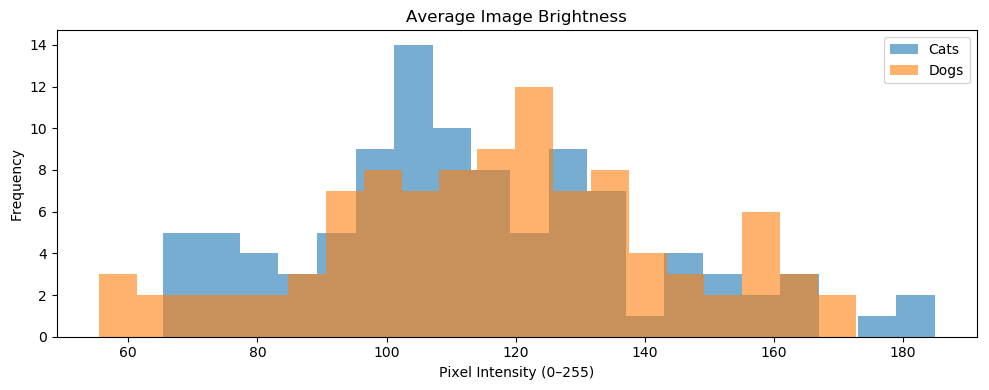

In [5]:
# Analyze grayscale brightness levels to understand lighting consistency
from PIL import ImageOps

# Function to convert images to grayscale and compute average brightness
def brightness(folder):
    brightness_vals = []
    for file in os.listdir(folder)[:100]:
        with Image.open(folder / file) as img:
            gray = ImageOps.grayscale(img)
            brightness_vals.append(np.mean(gray))
    return brightness_vals

# Brightness analysis for cats and dogs
cat_brightness = brightness(new_base_dir / "train" / "cat")
dog_brightness = brightness(new_base_dir / "train" / "dog")

# Plot brightness histogram
plt.figure(figsize=(10, 4))
plt.hist(cat_brightness, bins=20, alpha=0.6, label="Cats")
plt.hist(dog_brightness, bins=20, alpha=0.6, label="Dogs")
plt.title("Average Image Brightness")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


#### **Data Augmentation with ImageDataGenerator**

#### **Step 5: Previewing Augmented Images**
To improve generalization and avoid overfitting, I apply augmentation techniques like rotation, flipping, zooming, and shifting. This step visually demonstrates the impact of augmentation using ImageDataGenerator from Keras.

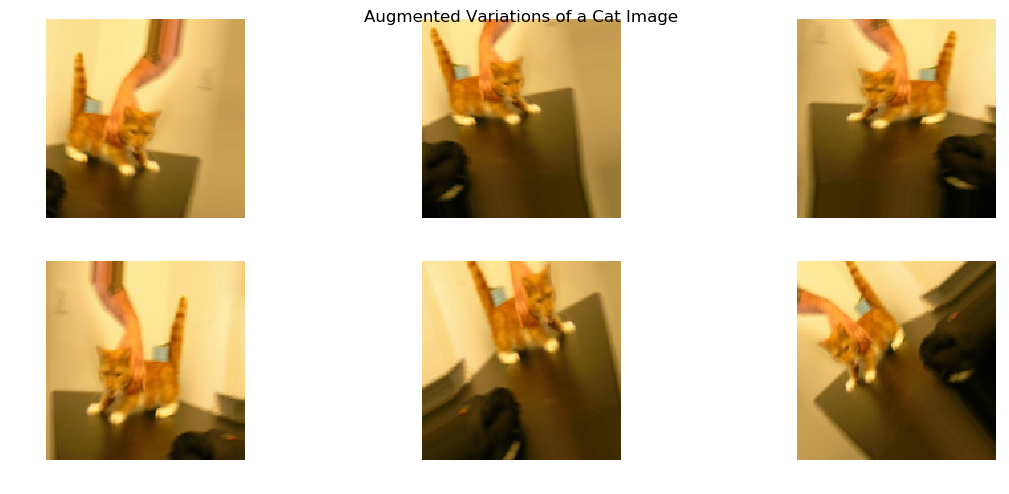

In [6]:
# Preview augmented images from a single input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Initialize data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load one image and convert it to an array
img_path = new_base_dir / "train" / "cat" / os.listdir(new_base_dir / "train" / "cat")[0]
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Display 6 variations using the generator
plt.figure(figsize=(12, 5))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(batch[0])
    plt.axis("off")
    if i == 5:
        break
plt.suptitle("Augmented Variations of a Cat Image")
plt.tight_layout()
plt.show()


In [7]:
# Training: With augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    new_base_dir / "train",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Validation/Test: Only rescale
test_val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_val_datagen.flow_from_directory(
    new_base_dir / "validation",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    new_base_dir / "test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**Preview: Augmented Training Images – Cats & Dogs**

This cell visually inspects how data augmentation is applied to each class. It shows 5 randomly augmented images from each class in a clean, readable layout.

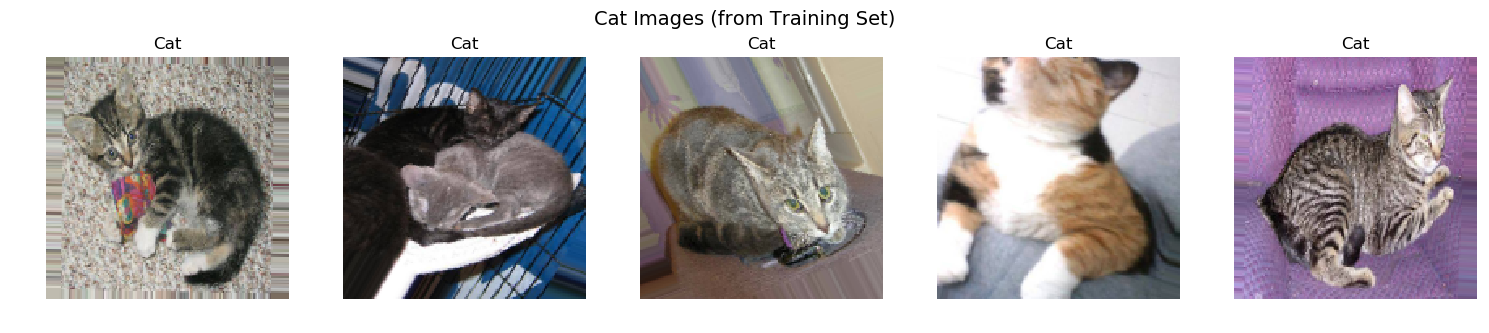

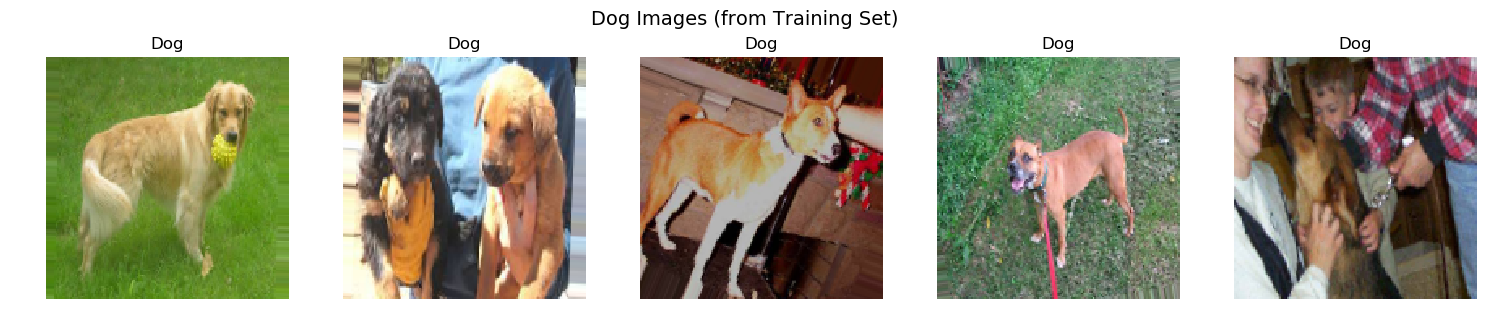

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch one batch from the train generator
augmented_images, augmented_labels = next(train_generator)

# Separate cats and dogs from the batch
cat_images = [augmented_images[i] for i in range(len(augmented_labels)) if augmented_labels[i] == 0][:5]
dog_images = [augmented_images[i] for i in range(len(augmented_labels)) if augmented_labels[i] == 1][:5]

# Plot 5 cat images
plt.figure(figsize=(15, 3))
plt.suptitle("Cat Images (from Training Set)", fontsize=14, y=1.15)  # Adds spacing above the images
for i, img in enumerate(cat_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title("Cat")
    plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=1.10)  # Extra space for header
plt.show()

# Plot 5 dog images
plt.figure(figsize=(15, 3))
plt.suptitle("Dog Images (from Training Set)", fontsize=14, y=1.15)
for i, img in enumerate(dog_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title("Dog")
    plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=1.10)
plt.show()


**Summary of EDA:**      
This section summarizes all key observations from the EDA process, including dataset balance, image variety, dimensional consistency, brightness levels, and the benefits of augmentation. These insights validate that the dataset is ready for the modeling phase.

## **Train two networks (use callbacks to save the best model version):**

### **Model 1: Custom Vanilla CNN**

**Introduction**        
In this section, I develop a Vanilla Convolutional Neural Network (CNN) from scratch to classify dog and cat images. The model is trained on augmented image data using `ImageDataGenerator`. To ensure optimal performance, I employ two essential callbacks:

- `ModelCheckpoint`: Saves the model with the highest validation accuracy

- `EarlyStopping`: Prevents overfitting by stopping training when performance stagnates

This model serves as the first of two required architectures for the lab.

#### **Step 1: Define the CNN Architecture**

Define a simple sequential CNN with three convolutional layers, max pooling, a dense fully connected layer, dropout for regularization, and a sigmoid output for binary classification.

In [9]:
from tensorflow.keras import models, layers

# Build a sequential CNN model
model_cnn = models.Sequential([
    # Input Layer
    layers.Input(shape=(150, 150, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# View the architecture
model_cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

#### **Step 2: Configure Callbacks to Save the Best Model**

Configure callbacks to monitor performance during training.
- ModelCheckpoint: Saves the best model based on validation accuracy.
- EarlyStopping: Stops training early if validation loss doesn’t improve.

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Create directory to store best model
os.makedirs("Models", exist_ok=True)

# Callback to save best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="Models/cnn_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback to stop training if val_loss doesn’t improve
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


#### **Step 3: Train the Model on Augmented Data**
Train the CNN using the train_generator and validate with validation_generator. The model will automatically save the best weights and avoid overfitting.

In [12]:
# Fit the model using augmented training data
history_cnn = model_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.4965
Epoch 1: val_accuracy improved from -inf to 0.60100, saving model to Models\cnn_model.h5
63/63 [==============================] - 43s 667ms/step - loss: 0.7294 - accuracy: 0.4965 - val_loss: 0.6906 - val_accuracy: 0.6010
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5320
Epoch 2: val_accuracy did not improve from 0.60100
63/63 [==============================] - 39s 607ms/step - loss: 0.6931 - accuracy: 0.5320 - val_loss: 0.6905 - val_accuracy: 0.5720
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5725
Epoch 3: val_accuracy improved from 0.60100 to 0.61500, saving model to Models\cnn_model.h5
63/63 [==============================] - 43s 679ms/step - loss: 0.6850 - accuracy: 0.5725 - val_loss: 0.6518 - val_accuracy: 0.6150
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.5

#### **Step 4: Training and Validation Curves for Custom CNN**

This section visualizes the learning progress of the custom CNN by plotting training and validation accuracy and loss over epochs. These plots help assess model generalization and detect overfitting.

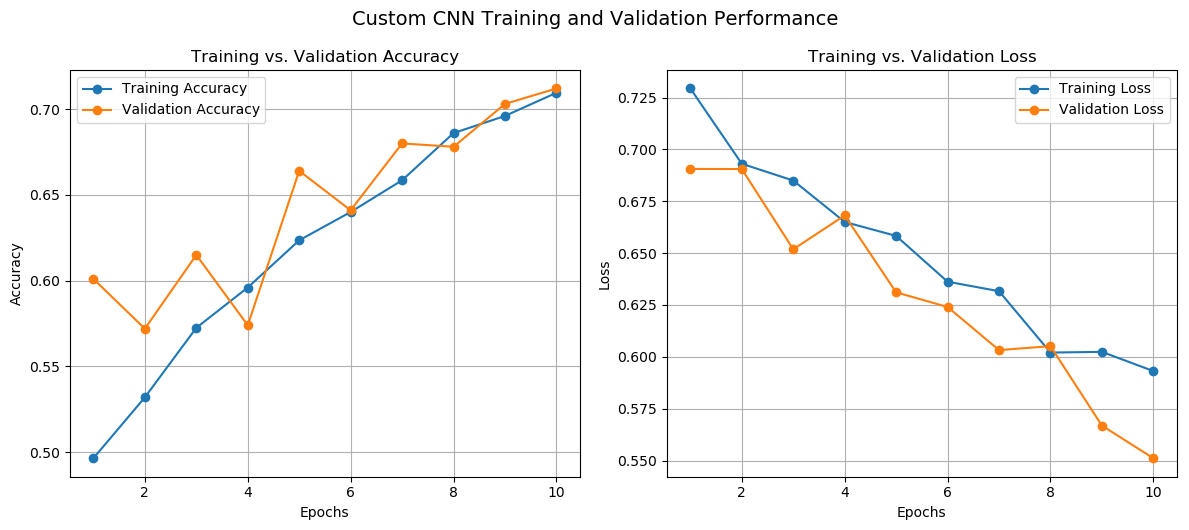

In [22]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Main title and layout adjustments
plt.suptitle("Custom CNN Training and Validation Performance", fontsize=14, y=1.05)
plt.tight_layout()
plt.subplots_adjust(top=.93)  # Adjust space below the suptitle

plt.show()


#### **Step 5: Model Evaluation on Test Set**

Once the best model is saved during training, it's crucial to evaluate its final performance on the test set, which was kept completely separate from both training and validation. This gives an unbiased estimate of real-world performance.